# QPD Diameter Trade-Off with Frequency Plan Input

In [76]:
# TODO: propagate all major parameters all the way to the final performance data for documentation.
# TODO: allow multiple evaluations with different parameter sets without manual intervention
# TODO: improve documentation 

In [77]:
import pandas as pd
import pprint
from typing import List
from functools import partial
import numpy
from matplotlib import pyplot
pyplot.style.use('dark_background')


In [78]:
model_parameters = {}

def define_parameter(name, value):
    model_parameters.update({name: value})
    return value
def use_parameter(name):
    value = model_parameters.get(name,None)
    if not value:
        raise LookupError
    else:
        return value

## Load Frequency plan

In [79]:
with open("Data/example_f.dat", "r") as fp_file:
    fp_data = pd.read_csv(fp_file, sep=" ", header = None, skiprows=2)

print(fp_data)

           0       1      2    3      4      5       6       7       8
0     -5.300  -9.996 -6.543  5.0 -6.239 -7.280  14.486  22.490  20.986
1     -5.322 -10.001 -6.542  5.0 -6.237 -7.345  14.422  22.484  20.955
2     -5.345 -10.009 -6.541  5.0 -6.236 -7.415  14.354  22.475  20.923
3     -5.371 -10.020 -6.539  5.0 -6.235 -7.488  14.282  22.463  20.889
4     -5.398 -10.033 -6.538  5.0 -6.233 -7.567  14.205  22.448  20.853
...      ...     ...    ...  ...    ...    ...     ...     ...     ...
3923 -16.827 -18.463 -5.194  5.0 -5.275 -6.567  22.103  21.599   5.505
3924 -16.865 -18.284 -5.179  5.0 -5.286 -6.659  21.999  21.790   5.481
3925 -16.896 -18.102 -5.165  5.0 -5.297 -6.754  21.893  21.983   5.465
3926 -16.919 -17.918 -5.153  5.0 -5.305 -6.852  21.786  22.175   5.453
3927 -16.927 -17.817 -5.149  5.0 -5.309 -6.908  21.728  22.280   5.449

[3928 rows x 9 columns]


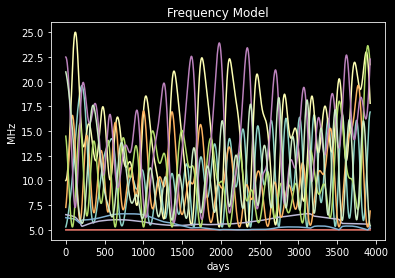

In [80]:
fp_plot = pyplot.plot(abs(fp_data))
pyplot.xlabel("days")
pyplot.ylabel("MHz")
pyplot.title("Frequency Model")
pyplot.show(fp_plot)

## Generate QPR Noise Model

The input noise model has been previously established via EXCEL based analysis and manually tuned to the latest NIKEHF measurements.

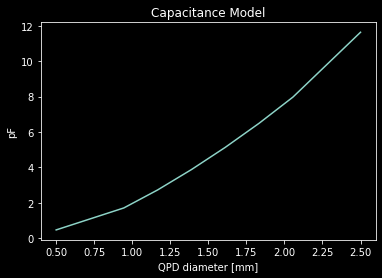

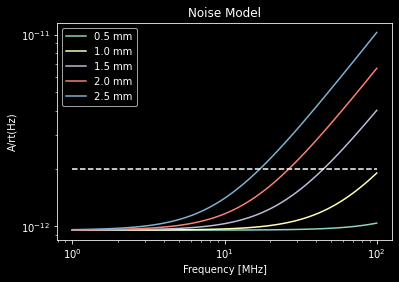

In [81]:
R_FB = 42200 #Ohms
T = 294 #K
k = 1.38e-23 #J/K
I_OP = 0.725 #pA/rt(Hz)
U_OP = 1.4 #nV/rt(Hz)

define_parameter('capacity_factor', 1.0)

capacitance = lambda d: use_parameter("capacity_factor")*numpy.interp(d, [0.5, 1.0, 1.5, 2.0, 2.5], [0.465, 1.861, 4.450, 7.510, 11.634])
input_noise = lambda f,c: numpy.sqrt(4*k*T/R_FB+(I_OP*1e-12)**2+(U_OP*1e-9*2*numpy.pi*f*1e6*c*1e-12)**2)

c_range = numpy.linspace(0.5,2.5,10)
c_plot = pyplot.plot(c_range, capacitance(c_range))
pyplot.title("Capacitance Model")
pyplot.xlabel("QPD diameter [mm]")
pyplot.ylabel("pF")

f_range = [1*10**x for x in numpy.linspace(0,2,100)]

f_plot = pyplot.figure()

for d in [0.5,1.0,1.5,2.0,2.5]:
    pyplot.plot(f_range, [input_noise(f,capacitance(d)) for f in f_range], label=f"{d} mm")
pyplot.loglog()
pyplot.title("Noise Model")
pyplot.xlabel("Frequency [MHz]")
pyplot.ylabel("A/rt(Hz)")
pyplot.legend()
pyplot.plot([f_range[0],f_range[-1]],[2e-12,2e-12], linestyle = "dashed", color="white")



### QPR Noise Envelope Requirement

For the purpose of requirements engineering, a simple envelope for the allowable/required QPR noise shall be defined.

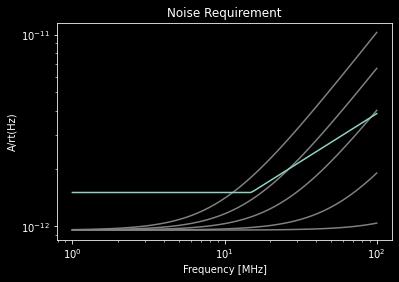

In [82]:
def input_noise_requirement(f,c):

    knee_freq = 15 #MHz
    base_level= 1.5e-12

    if f< knee_freq:
        return base_level
    else:
        return base_level*(f/knee_freq)**0.5

pyplot.figure()
for d in [0.5,1.0,1.5,2.0,2.5]:
    pyplot.plot(f_range, [input_noise(f,capacitance(d)) for f in f_range], label=f"{d} mm", color="grey")
pyplot.loglog()
pyplot.title("Noise Requirement")
pyplot.xlabel("Frequency [MHz]")
pyplot.ylabel("A/rt(Hz)")
pyplot.plot(f_range, [input_noise_requirement(f,None) for f in f_range])

    


## Combine Noise model with frequency plan

We take the max of the daily rms of the six largest noise contributors

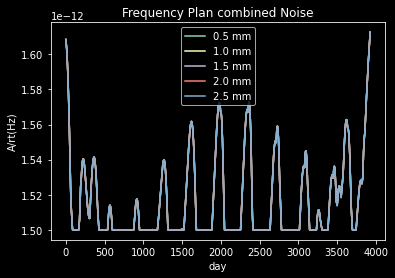

In [83]:
combined_noise = pyplot.figure()

max_noise_6 = {}
max_noise_9 = {}

for d in [0.5,1.0,1.5,2.0,2.5]:

    noise_map_func = lambda f: input_noise(f, capacitance(d))
    noise_map_func = lambda f: input_noise_requirement(f, None)

    noise_map = fp_data.applymap(noise_map_func)

    #make the rms removing the 2 smallest values first
    rms_6 = noise_map.apply(lambda noise: (numpy.mean([x**2 for x in noise.sort_values()[3:]]))**0.5, axis=1)
    rms_9 = noise_map.apply(lambda noise: (numpy.mean([x**2 for x in noise.sort_values()[:]]))**0.5, axis=1)

    max_noise_6[d]=max(rms_6)

    max_noise_9[d]=max(rms_9)

    pyplot.plot(rms_6, label=f"{d} mm")

pyplot.title("Frequency Plan combined Noise")
pyplot.xlabel("day")
pyplot.ylabel("A/rt(Hz)")
pyplot.legend()
#pyplot.plot(pyplot.gca().get_xlim(),[2e-12,2e-12], linestyle = "dashed", color="white")
pyplot.show(combined_noise)


In [84]:
pprint.pprint(max_noise_6)

{0.5: 1.6125135658344089e-12,
 1.0: 1.6125135658344089e-12,
 1.5: 1.6125135658344089e-12,
 2.0: 1.6125135658344089e-12,
 2.5: 1.6125135658344089e-12}


## Sensitivity of the Top Level Performance

Extracted from sensitivity analysis of the CCPM for Input Noise and TTL

In [85]:
# This data has been ectracted via a a CCPM sensitivity analysis for a range of different input noise values
# This has been independently done by EB and MH with essentially identical results.


ccpm_inp_noise= [5.000000E-13,	
                 8.333334E-13,	
                 1.166660E-12,	
                 1.500000E-12,	
                 1.833340E-12,	
                 2.166660E-12,	
                 2.500000E-12,	
                 2.833334E-12,	
                 3.166666E-12,	
                 3.500000E-12]	

ccpm_tdi_x = [3.1896160E-11,
              3.2424520E-11,
              3.3201240E-11,
              3.4209510E-11,
              3.5429530E-11,
              3.6839900E-11,
              3.8420600E-11,
              4.0151030E-11,
              4.2011550E-11,
              4.3987730E-11]

estimate_perf= lambda inp_noise, ttl: numpy.interp(inp_noise, ccpm_inp_noise, ccpm_tdi_x) 

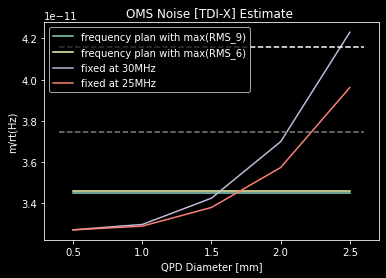

In [86]:
performance_plot = pyplot.figure()
pyplot.plot(max_noise_9.keys(), [estimate_perf(noise,0) for noise in max_noise_9.values()], label="frequency plan with max(RMS_9)")
pyplot.plot(max_noise_6.keys(), [estimate_perf(noise,0) for noise in max_noise_6.values()], label="frequency plan with max(RMS_6)")
pyplot.plot(max_noise_6.keys(), [estimate_perf(input_noise(30,capacitance(d)),0) for d in max_noise_6.keys()], label="fixed at 30MHz")
pyplot.plot(max_noise_6.keys(), [estimate_perf(input_noise(25,capacitance(d)),0) for d in max_noise_6.keys()], label="fixed at 25MHz")
limits=pyplot.gca().get_xlim()
pyplot.plot(limits,[4.16e-11,4.16e-11], linestyle = "dashed", color="white")
pyplot.plot(limits,[0.9*4.16e-11,0.9*4.16e-11], linestyle = "dashed", color="grey")
pyplot.title("OMS Noise [TDI-X] Estimate ")
pyplot.xlabel("QPD Diameter [mm]")
pyplot.ylabel("m/rt(Hz)")
pyplot.legend()
pyplot.show(performance_plot)

## TTL Coefficients derivation

in general the CCPM has 4 parameters for TTL in connection with the IDS:

- C_Tx_IDS
- C_Tx_STdrift_IDS
- C_Rx_IDS
- C_Rx_STdrift_IDS

It is clear that the alignment and stability of the QPDs does not have any influence on the TX path since neither the QPR nor the QPR Imaging system is a part of the TX path

TO prepare this, the TTL STOP Model / BUdget has to be evaluated first however. Since everything is summed up in RSS we can easily extract and recombine individual values from the budsget at will since in general the equation below is true:

$$ \sqrt{{n_1}^2+{n_2}^2+...+{n_i}^2} = \sqrt{{\sqrt{{n_1}^2+{n_2}^2+...+ {n_{i-1}}^2}}^2 + {n_i}^2} $$

So from the TTL Stop model we can extract the TTL factors for the various mission phases excluding QPD



Budgets (averaged between DOFs) from the TTL Stop Model with the QPD dependent entries removed are:

| Path    |      AIVT     |  Calibration  |   GTO   |  Long-Term | Short-Term  |
|---------|:-------------:|:-------------:|:-------:|:----------:|:-----------:| 
| TX      |  4.4345 mm/rad       |       0.134 mm/rad   |  0.3411 mm/rad |    0.3017 mm/rad  |      0.0400 mm/rad |
| RX      |  3.9931 mm/rad       |       0.134 mm/rad   |  0.3202 mm/rad |    0.3012 mm/rad  |      0.0400 mm/rad |

In addition we also want to understand the impact on the overall budgets (especially for BAM correction).
Table below gives full TTL budget without QPD effect

| Path    |      AIVT     |  Calibration  |   GTO   |  Long-Term | Short-Term  |
|---------|:-------------:|:-------------:|:-------:|:----------:|:-----------:| 
| RX      |  8.2432 mm/rad       |       1.292 mm/rad   |  1.101 mm/rad |    0.5866 mm/rad  |      0.0964 mm/rad |

In [87]:
# Table is used as input for a python dict:

TTL_budgets= {"TX":{"AIVT":         4.4345e-3,
                    "Calibration":  0.134e-3,
                    "GTO":          0.3411e-3,
                    "LongTerm":    0.3017e-3,
                    "ShortTerm":   0.0400e-3},
              "RX":{"AIVT":         3.9931e-3,
                    "Calibration":  0.134e-3,
                    "GTO":          0.3202e-3,
                    "LongTerm":    0.3012e-3,
                    "ShortTerm":   0.0400e-3},
            }

TTL_budgets_complete = {"RX":{"AIVT":         8.2432e-3,
                              "Calibration":  1.292e-3,
                              "GTO":          1.101e-3,
                              "LongTerm":    0.5866e-3,
                              "ShortTerm":   0.0964e-3}}

The contribution of the QPD for each of the Phases is elaborated hereafter.
Generally the QPD diameter comes into effect via the OB imaging system magnification factor. The total maginification factor from QPD refrence sysetem to insertial space is 

$$ M_{tot} = M_{im} \cdot M_{Tel} $$

The magnification of the imaging system is set at 0.4 for a 1mm diode producing a coupling of 0.0001962 m/rad/µm as per "EF" analysis [RDXX]

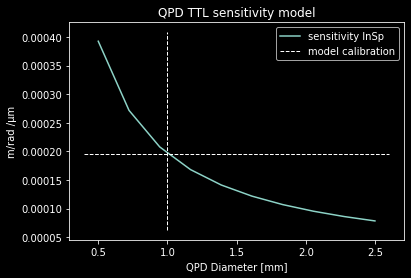

In [105]:
# Assumptions that need to be made:

define_parameter("alignment_factor",2)
define_parameter("slip_factor", 2)
define_parameter("thermal_factor",10)

uP=use_parameter

#QPD_lat_aligment_accuracy = alignment_factor *      10e-6 # QPD lateral alignment accuracy
#QPD_long_aligment_accuracy = 2e-3 # QPD longitudinal alignment accuracy

QPD_1mm_lat_sensitivity = 0.0001962 #m/rad/µm from EF analysis  

QPD_lat_sensitivity = lambda d: QPD_1mm_lat_sensitivity*(1.0/d)

QPD_lat_coupling = lambda d, tol: QPD_lat_sensitivity(d)*tol

QPD_lat_thermal_sensitivity = 0.1 #µm/K

d_range = numpy.linspace(0.5,2.5,10)
pyplot.figure
pyplot.plot(d_range, [QPD_lat_sensitivity(d) for d in d_range], label = "sensitivity InSp")
pyplot.title("QPD TTL sensitivity model")
pyplot.xlabel("QPD Diameter [mm]")
pyplot.ylabel("m/rad /µm")


limits=pyplot.gca().get_ylim()
pyplot.plot([1,1],limits, linestyle = "dashed", color="white", linewidth= 1)
limits=pyplot.gca().get_xlim()
pyplot.plot(limits, [QPD_1mm_lat_sensitivity, QPD_1mm_lat_sensitivity], linestyle = "dashed", color="white", label="model calibration", linewidth= 1)
pyplot.legend()

pyplot.show()


With the diameter dependent sensitivity as shown above we can rebuild the full TTL budget for the different mission phases. For this the different contributors for each phase need to be assembled.

In [106]:
def AIVT_alignment(d,tol): 
    return QPD_lat_coupling(d, tol)

def GTO_thermal(d,dT): 
    return QPD_lat_sensitivity(d)*QPD_lat_thermal_sensitivity*dT

def GTO_hysteresis(d,tol):
    return QPD_lat_coupling(d, tol)

def LongTerm_thermal(d, dT):
    return QPD_lat_sensitivity(d)*QPD_lat_thermal_sensitivity*dT

def ShortTerm_thermal(d, dT):
    return QPD_lat_sensitivity(d)*QPD_lat_thermal_sensitivity*dT


QPD_AIVT = lambda d: [AIVT_alignment(d,uP("alignment_factor") * 10)]
QPD_GTO = lambda d:  [GTO_thermal(d, 10), GTO_hysteresis(d, uP("slip_factor") * 5)]
QPD_LongTerm = lambda d: [LongTerm_thermal(d, uP("thermal_factor") *2)]
QPD_ShortTerm = lambda d: [ShortTerm_thermal(d, uP("thermal_factor") * 3.4e-2)]


def rss(elements: List)-> float:

    return numpy.sqrt(numpy.sum([e**2 for e in elements]))
    


print(QPD_AIVT(1), QPD_GTO(1), QPD_LongTerm(1), QPD_ShortTerm(1))

RX_AIVT = lambda d:         rss([TTL_budgets["RX"]["AIVT"]]         + QPD_AIVT(d))
RX_Calib = lambda d:        rss([TTL_budgets["RX"]["Calibration"]])
RX_GTO = lambda d:          rss([TTL_budgets["RX"]["GTO"]]          + QPD_GTO(d)) 
RX_LongTerm = lambda d:     rss([TTL_budgets["RX"]["LongTerm"]]     + QPD_LongTerm(d)) 
RX_ShortTerm = lambda d:    rss([TTL_budgets["RX"]["ShortTerm"]]    + QPD_ShortTerm(d)) 

print(RX_AIVT(1),RX_Calib(1), RX_GTO(1), RX_LongTerm(1), RX_ShortTerm(1))

# THis has been checked against TTL STOP Model for d=1.0

[0.003924] [0.00019620000000000003, 0.001962] [0.00039240000000000005] [6.670800000000001e-06]
0.005598448321633416 0.000134 0.0019976151981800703 0.0004946707996233455 4.055242992275556e-05


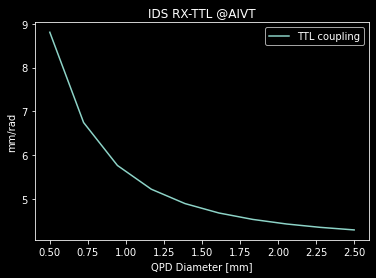

In [107]:
pyplot.figure()
pyplot.plot(d_range, [1e3*RX_AIVT(d) for d in d_range], label = "TTL coupling")
pyplot.title("IDS RX-TTL @AIVT")
pyplot.xlabel("QPD Diameter [mm]")
pyplot.ylabel("mm/rad")
pyplot.legend()
pyplot.show()

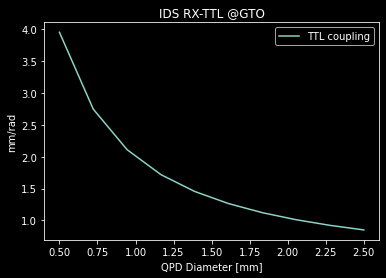

In [108]:
pyplot.figure()
pyplot.plot(d_range, [1e3*RX_GTO(d) for d in d_range], label = "TTL coupling")
pyplot.title("IDS RX-TTL @GTO")
pyplot.xlabel("QPD Diameter [mm]")
pyplot.ylabel("mm/rad")
pyplot.legend()
pyplot.show()

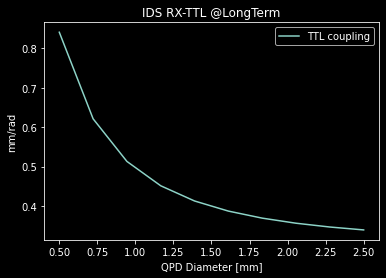

In [109]:
pyplot.figure()
pyplot.plot(d_range, [1e3*RX_LongTerm(d) for d in d_range], label = "TTL coupling")
pyplot.title("IDS RX-TTL @LongTerm")
pyplot.xlabel("QPD Diameter [mm]")
pyplot.ylabel("mm/rad")
pyplot.legend()
pyplot.show()

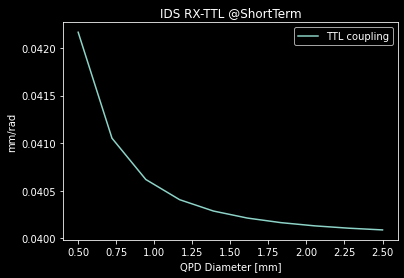

In [110]:
pyplot.figure()
pyplot.plot(d_range, [1e3*RX_ShortTerm(d) for d in d_range], label = "TTL coupling")
pyplot.title("IDS RX-TTL @ShortTerm")
pyplot.xlabel("QPD Diameter [mm]")
pyplot.ylabel("mm/rad")
pyplot.legend()
pyplot.show()

The next step is to compute the input values for the Performance model evaluation which is a combination of the mission phase output as will be defined in the codeblock below

In [111]:
RX_c_ttl = lambda d: rss([RX_Calib(d), RX_GTO(d), RX_LongTerm(d)])
RX_c_ttl_drift = lambda d: RX_ShortTerm(d)

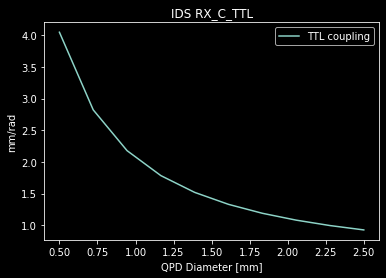

In [112]:
pyplot.figure()
pyplot.plot(d_range, [1e3*RX_c_ttl(d) for d in d_range], label = "TTL coupling")
pyplot.title("IDS RX_C_TTL")
pyplot.xlabel("QPD Diameter [mm]")
pyplot.ylabel("mm/rad")
pyplot.legend()
pyplot.show()

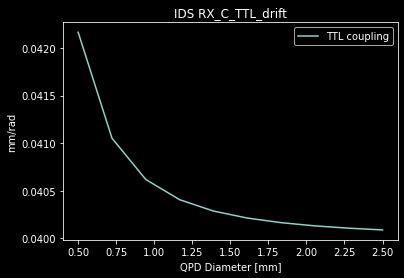

In [113]:
pyplot.figure()
pyplot.plot(d_range, [1e3*RX_c_ttl_drift(d) for d in d_range], label = "TTL coupling")
pyplot.title("IDS RX_C_TTL_drift")
pyplot.xlabel("QPD Diameter [mm]")
pyplot.ylabel("mm/rad")
pyplot.legend()
pyplot.show()

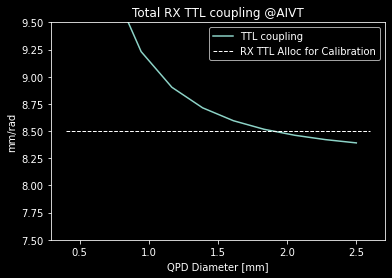

In [114]:
Full_RX_AIVT = lambda d:         rss([TTL_budgets_complete["RX"]["AIVT"]]         + QPD_AIVT(d))

pyplot.figure()
pyplot.plot(d_range, [1e3*Full_RX_AIVT(d) for d in d_range], label = "TTL coupling")
pyplot.title("Total RX TTL coupling @AIVT")
pyplot.xlabel("QPD Diameter [mm]")
pyplot.ylabel("mm/rad")

pyplot.ylim(7.5,9.5)
limits=pyplot.gca().get_xlim()
pyplot.plot(limits, [8.5 ,8.5], linestyle = "dashed", color="white", label="RX TTL Alloc for Calibration", linewidth= 1)
pyplot.legend()
pyplot.show()


With this complete set of modelling we can derive parameter tuples for each diameter of interest and run it through the CCPM, this can only work on a local machine of course!

In [115]:
import lpm_update
import subprocess
import os

CCPM_basedir="C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1"


for d in d_range:
    lpm_update_data = {"C_Rx_IDS": RX_c_ttl(d), "C_Rx_STdrift_IDS": RX_c_ttl_drift(d), "s_I_seg_el_LA": f"{numpy.interp(d,list(max_noise_6.keys()),list(max_noise_6.values()))}*sqrt(1+(2E-3./f).^4)"}
    
    lpm_update.update_lpm_inputs(CCPM_basedir+"/inputs",f"QPD_{int(d*100)}",lpm_update_data,lpm_update_data)
    
    batch_input =f'matlab -batch "ltpda_startup; modelName=\'QPD_{int(d*100)}\'; disp(modelName); generateNSDF; exit"'
    print(batch_input)
    result = subprocess.Popen(batch_input, shell=True, stdout=subprocess.PIPE, cwd=CCPM_basedir).stdout
    print(result.read())



model path exists already....cleaning up

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_50/CCPM_constan
ts.csv

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_50/CCPM_noiseIn
puts.csv

Updating input for C_Rx_IDS

C_Rx_IDS is NOT in the input file

Updating input for C_Rx_STdrift_IDS

C_Rx_STdrift_IDS is NOT in the input file

Updating input for s_I_seg_el_LA

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_50/CCPM_paramet
ers.csv

Updating input for C_Rx_IDS

Updating input for C_Rx_STdrift_IDS

Updating input for s_I_seg_el_LA

s_I_seg_el_LA is NOT in the input file

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_50/CCPM_transfe
rFunctions.csv

matlab -batch "ltpda_startup; modelName='QPD_50'; disp(modelName); generateNSDF; exit"
b"[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\r2019b]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 1)]\x08 \r\n[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\coder]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 2)]\x08 \r\n* installing extensions under C:\\Users\\EliasBreunig\\MATLAB\\addons\\nsd_matlab ...\r\n[\x08Warning: Class 'timespan' defines property 'timezone' as Constant and also\r\ndefines a property get-method for 'timezone'.  Defining a property get-method\r\nfor a Constant property will not be supported in future releases.  This warning\r\nwill become an error in a future release.]\x08 \r\n[\x08> In utils.helper.ltpda_userclasses (line 32)\r\n  In utils.modules.installExten

model path exists already....cleaning up

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_72/CCPM_constan
ts.csv

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_72/CCPM_noiseIn
puts.csv

Updating input for C_Rx_IDS

C_Rx_IDS is NOT in the input file

Updating input for C_Rx_STdrift_IDS

C_Rx_STdrift_IDS is NOT in the input file

Updating input for s_I_seg_el_LA

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_72/CCPM_paramet
ers.csv

Updating input for C_Rx_IDS

Updating input for C_Rx_STdrift_IDS

Updating input for s_I_seg_el_LA

s_I_seg_el_LA is NOT in the input file

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_72/CCPM_transfe
rFunctions.csv

matlab -batch "ltpda_startup; modelName='QPD_72'; disp(modelName); generateNSDF; exit"
b"[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\r2019b]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 1)]\x08 \r\n[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\coder]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 2)]\x08 \r\n* installing extensions under C:\\Users\\EliasBreunig\\MATLAB\\addons\\nsd_matlab ...\r\n[\x08Warning: Class 'timespan' defines property 'timezone' as Constant and also\r\ndefines a property get-method for 'timezone'.  Defining a property get-method\r\nfor a Constant property will not be supported in future releases.  This warning\r\nwill become an error in a future release.]\x08 \r\n[\x08> In utils.helper.ltpda_userclasses (line 32)\r\n  In utils.modules.installExten

model path exists already....cleaning up

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_94/CCPM_constan
ts.csv

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_94/CCPM_noiseIn
puts.csv

Updating input for C_Rx_IDS

C_Rx_IDS is NOT in the input file

Updating input for C_Rx_STdrift_IDS

C_Rx_STdrift_IDS is NOT in the input file

Updating input for s_I_seg_el_LA

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_94/CCPM_paramet
ers.csv

Updating input for C_Rx_IDS

Updating input for C_Rx_STdrift_IDS

Updating input for s_I_seg_el_LA

s_I_seg_el_LA is NOT in the input file

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_94/CCPM_transfe
rFunctions.csv

matlab -batch "ltpda_startup; modelName='QPD_94'; disp(modelName); generateNSDF; exit"
b"[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\r2019b]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 1)]\x08 \r\n[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\coder]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 2)]\x08 \r\n* installing extensions under C:\\Users\\EliasBreunig\\MATLAB\\addons\\nsd_matlab ...\r\n[\x08Warning: Class 'timespan' defines property 'timeformat' as Constant and also\r\ndefines a property get-method for 'timeformat'.  Defining a property get-method\r\nfor a Constant property will not be supported in future releases.  This warning\r\nwill become an error in a future release.]\x08 \r\n[\x08> In utils.helper.ltpda_userclasses (line 32)\r\n  In utils.modules.installE

model path exists already....cleaning up

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_116/CCPM_consta
nts.csv

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_116/CCPM_noiseI
nputs.csv

Updating input for C_Rx_IDS

C_Rx_IDS is NOT in the input file

Updating input for C_Rx_STdrift_IDS

C_Rx_STdrift_IDS is NOT in the input file

Updating input for s_I_seg_el_LA

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_116/CCPM_parame
ters.csv

Updating input for C_Rx_IDS

Updating input for C_Rx_STdrift_IDS

Updating input for s_I_seg_el_LA

s_I_seg_el_LA is NOT in the input file

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_116/CCPM_transf
erFunctions.csv

matlab -batch "ltpda_startup; modelName='QPD_116'; disp(modelName); generateNSDF; exit"
b"[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\r2019b]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 1)]\x08 \r\n[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\coder]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 2)]\x08 \r\n* installing extensions under C:\\Users\\EliasBreunig\\MATLAB\\addons\\nsd_matlab ...\r\n[\x08Warning: Class 'timespan' defines property 'timeformat' as Constant and also\r\ndefines a property get-method for 'timeformat'.  Defining a property get-method\r\nfor a Constant property will not be supported in future releases.  This warning\r\nwill become an error in a future release.]\x08 \r\n[\x08> In utils.helper.ltpda_userclasses (line 32)\r\n  In utils.modules.install

model path exists already....cleaning up

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_138/CCPM_consta
nts.csv

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_138/CCPM_noiseI
nputs.csv

Updating input for C_Rx_IDS

C_Rx_IDS is NOT in the input file

Updating input for C_Rx_STdrift_IDS

C_Rx_STdrift_IDS is NOT in the input file

Updating input for s_I_seg_el_LA

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_138/CCPM_parame
ters.csv

Updating input for C_Rx_IDS

Updating input for C_Rx_STdrift_IDS

Updating input for s_I_seg_el_LA

s_I_seg_el_LA is NOT in the input file

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_138/CCPM_transf
erFunctions.csv

matlab -batch "ltpda_startup; modelName='QPD_138'; disp(modelName); generateNSDF; exit"
b"[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\r2019b]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 1)]\x08 \r\n[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\coder]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 2)]\x08 \r\n* installing extensions under C:\\Users\\EliasBreunig\\MATLAB\\addons\\nsd_matlab ...\r\n[\x08Warning: Class 'timespan' defines property 'timeformat' as Constant and also\r\ndefines a property get-method for 'timeformat'.  Defining a property get-method\r\nfor a Constant property will not be supported in future releases.  This warning\r\nwill become an error in a future release.]\x08 \r\n[\x08> In utils.helper.ltpda_userclasses (line 32)\r\n  In utils.modules.install

model path exists already....cleaning up

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_161/CCPM_consta
nts.csv

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_161/CCPM_noiseI
nputs.csv

Updating input for C_Rx_IDS

C_Rx_IDS is NOT in the input file

Updating input for C_Rx_STdrift_IDS

C_Rx_STdrift_IDS is NOT in the input file

Updating input for s_I_seg_el_LA

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_161/CCPM_parame
ters.csv

Updating input for C_Rx_IDS

Updating input for C_Rx_STdrift_IDS

Updating input for s_I_seg_el_LA

s_I_seg_el_LA is NOT in the input file

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_161/CCPM_transf
erFunctions.csv

matlab -batch "ltpda_startup; modelName='QPD_161'; disp(modelName); generateNSDF; exit"
b"[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\r2019b]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 1)]\x08 \r\n[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\coder]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 2)]\x08 \r\n* installing extensions under C:\\Users\\EliasBreunig\\MATLAB\\addons\\nsd_matlab ...\r\n[\x08Warning: Class 'timespan' defines property 'timezone' as Constant and also\r\ndefines a property get-method for 'timezone'.  Defining a property get-method\r\nfor a Constant property will not be supported in future releases.  This warning\r\nwill become an error in a future release.]\x08 \r\n[\x08> In utils.helper.ltpda_userclasses (line 32)\r\n  In utils.modules.installExte

model path exists already....cleaning up

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_183/CCPM_consta
nts.csv

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_183/CCPM_noiseI
nputs.csv

Updating input for C_Rx_IDS

C_Rx_IDS is NOT in the input file

Updating input for C_Rx_STdrift_IDS

C_Rx_STdrift_IDS is NOT in the input file

Updating input for s_I_seg_el_LA

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_183/CCPM_parame
ters.csv

Updating input for C_Rx_IDS

Updating input for C_Rx_STdrift_IDS

Updating input for s_I_seg_el_LA

s_I_seg_el_LA is NOT in the input file

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_183/CCPM_transf
erFunctions.csv

matlab -batch "ltpda_startup; modelName='QPD_183'; disp(modelName); generateNSDF; exit"
b"[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\r2019b]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 1)]\x08 \r\n[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\coder]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 2)]\x08 \r\n* installing extensions under C:\\Users\\EliasBreunig\\MATLAB\\addons\\nsd_matlab ...\r\n[\x08Warning: Class 'timespan' defines property 'timeformat' as Constant and also\r\ndefines a property get-method for 'timeformat'.  Defining a property get-method\r\nfor a Constant property will not be supported in future releases.  This warning\r\nwill become an error in a future release.]\x08 \r\n[\x08> In utils.helper.ltpda_userclasses (line 32)\r\n  In utils.modules.install

model path exists already....cleaning up

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_205/CCPM_consta
nts.csv

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_205/CCPM_noiseI
nputs.csv

Updating input for C_Rx_IDS

C_Rx_IDS is NOT in the input file

Updating input for C_Rx_STdrift_IDS

C_Rx_STdrift_IDS is NOT in the input file

Updating input for s_I_seg_el_LA

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_205/CCPM_parame
ters.csv

Updating input for C_Rx_IDS

Updating input for C_Rx_STdrift_IDS

Updating input for s_I_seg_el_LA

s_I_seg_el_LA is NOT in the input file

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_205/CCPM_transf
erFunctions.csv

matlab -batch "ltpda_startup; modelName='QPD_205'; disp(modelName); generateNSDF; exit"
b"[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\r2019b]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 1)]\x08 \r\n[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\coder]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 2)]\x08 \r\n* installing extensions under C:\\Users\\EliasBreunig\\MATLAB\\addons\\nsd_matlab ...\r\n[\x08Warning: Class 'timespan' defines property 'timeformat' as Constant and also\r\ndefines a property get-method for 'timeformat'.  Defining a property get-method\r\nfor a Constant property will not be supported in future releases.  This warning\r\nwill become an error in a future release.]\x08 \r\n[\x08> In utils.helper.ltpda_userclasses (line 32)\r\n  In utils.modules.install

model path exists already....cleaning up

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_227/CCPM_consta
nts.csv

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_227/CCPM_noiseI
nputs.csv

Updating input for C_Rx_IDS

C_Rx_IDS is NOT in the input file

Updating input for C_Rx_STdrift_IDS

C_Rx_STdrift_IDS is NOT in the input file

Updating input for s_I_seg_el_LA

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_227/CCPM_parame
ters.csv

Updating input for C_Rx_IDS

Updating input for C_Rx_STdrift_IDS

Updating input for s_I_seg_el_LA

s_I_seg_el_LA is NOT in the input file

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_227/CCPM_transf
erFunctions.csv

matlab -batch "ltpda_startup; modelName='QPD_227'; disp(modelName); generateNSDF; exit"
b"[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\r2019b]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 1)]\x08 \r\n[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\coder]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 2)]\x08 \r\n* installing extensions under C:\\Users\\EliasBreunig\\MATLAB\\addons\\nsd_matlab ...\r\n[\x08Warning: Class 'timespan' defines property 'timeformat' as Constant and also\r\ndefines a property get-method for 'timeformat'.  Defining a property get-method\r\nfor a Constant property will not be supported in future releases.  This warning\r\nwill become an error in a future release.]\x08 \r\n[\x08> In utils.helper.ltpda_userclasses (line 32)\r\n  In utils.modules.install

model path exists already....cleaning up

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_250/CCPM_consta
nts.csv

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_250/CCPM_noiseI
nputs.csv

Updating input for C_Rx_IDS

C_Rx_IDS is NOT in the input file

Updating input for C_Rx_STdrift_IDS

C_Rx_STdrift_IDS is NOT in the input file

Updating input for s_I_seg_el_LA

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_250/CCPM_parame
ters.csv

Updating input for C_Rx_IDS

Updating input for C_Rx_STdrift_IDS

Updating input for s_I_seg_el_LA

s_I_seg_el_LA is NOT in the input file

C:/Users/EliasBreunig/MATLAB/projects/LPM21/ErrorBreakdown/PhaseB1/inputs/QPD_250/CCPM_transf
erFunctions.csv

matlab -batch "ltpda_startup; modelName='QPD_250'; disp(modelName); generateNSDF; exit"
b"[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\r2019b]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 1)]\x08 \r\n[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\coder]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 2)]\x08 \r\n* installing extensions under C:\\Users\\EliasBreunig\\MATLAB\\addons\\nsd_matlab ...\r\n[\x08Warning: Class 'timespan' defines property 'timezone' as Constant and also\r\ndefines a property get-method for 'timezone'.  Defining a property get-method\r\nfor a Constant property will not be supported in future releases.  This warning\r\nwill become an error in a future release.]\x08 \r\n[\x08> In utils.helper.ltpda_userclasses (line 32)\r\n  In utils.modules.installExte

In [116]:
performance_results={}

for d in d_range:  
    batch_input =f'matlab -batch "ltpda_startup; modelName=\'QPD_{int(d*100)}\'; disp(modelName); evalnode; exit"'
    print(batch_input)
    result = subprocess.Popen(batch_input, shell=True, stdout=subprocess.PIPE, cwd=CCPM_basedir+"/scripts/tutorials").stdout
    print(result.read())

    with open(CCPM_basedir+f"/m_out_QPD_{int(d*100)}.csv") as perf_out_file:

        perf_data = pd.read_csv(perf_out_file, index_col=0)

        performance_results[f"QPD_{int(d*100)}"]={"data": perf_data, "parameter": d}

matlab -batch "ltpda_startup; modelName='QPD_50'; disp(modelName); evalnode; exit"
b"[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\r2019b]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 1)]\x08 \r\n[\x08Warning: Name is nonexistent or not a directory: C:\\Program\r\nFiles\\AnsysEM\\AnsysEM21.2\\Win64\\cpl\\matlab\\coder]\x08 \r\n[\x08> In path (line 109)\r\n  In addpath (line 86)\r\n  In startup (line 2)]\x08 \r\n* installing extensions under C:\\Users\\EliasBreunig\\MATLAB\\addons\\nsd_matlab ...\r\n[\x08Warning: Class 'timespan' defines property 'timeformat' as Constant and also\r\ndefines a property get-method for 'timeformat'.  Defining a property get-method\r\nfor a Constant property will not be supported in future releases.  This warning\r\nwill become an error in a future release.]\x08 \r\n[\x08> In utils.helper.ltpda_userclasses (line 32)\r\n  In utils.modules.installExten

Last step of this analysis is to extract the quantities of interest of the generated CCPM instances based on the different input parameters. We are mainly interested in comparing top level perfomance (OMS noise or above).

This can be done by using the matlab routines available as part of the CCPM package

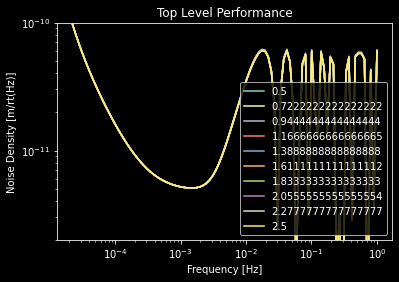

In [117]:
pyplot.figure()

for key, data in performance_results.items():
    pyplot.plot(data['data'], label=data['parameter'])

pyplot.loglog()

pyplot.title("Top Level Performance")
pyplot.xlabel("Frequency [Hz]")
pyplot.ylabel("Noise Density [m/rt(Hz)]")
#pyplot.plot(limits, [8.5 ,8.5], linestyle = "dashed", color="white", label="RX TTL Alloc for Calibration", linewidth= 1)
#pyplot.ylim(7.5,9.5)
pyplot.legend()
pyplot.ylim(2e-12,1e-10)
pyplot.show()

0.010151


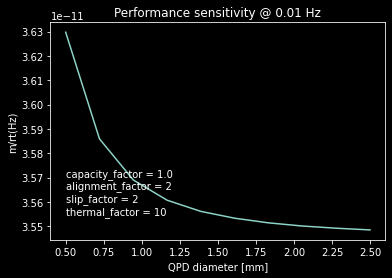

In [120]:
import pickle

select_frequency=56
x = [data['parameter'] for data in performance_results.values()]
y = [data['data'].iloc[select_frequency][0]  for data in performance_results.values()]

pyplot.plot(x,y)
frequency=list(performance_results.values())[0]['data'].index[select_frequency]
print(frequency)
pyplot.title(f"Performance sensitivity @ {frequency:.2f} Hz")
pyplot.xlabel("QPD diameter [mm]")
pyplot.ylabel("m/rt(Hz)")
pyplot.text(0.5,3.55e-11,"".join([f"{name} = {value}\n" for name, value in model_parameters.items()]))

with open("Results/F config.dat", "wb") as dump_file:
    pickle.dump([x,y,model_parameters], dump_file)


Below we are accumulating all data that has been stored in the Results

A config.dat
B config.dat
C config.dat
D config.dat
E config.dat
F config.dat


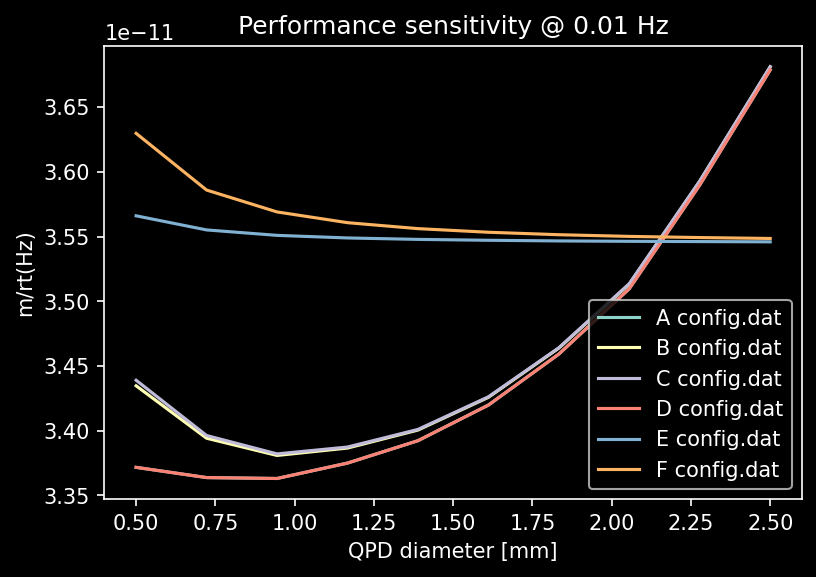

In [121]:
pyplot.figure(dpi=150)
pyplot.title(f"Performance sensitivity @ {frequency:.2f} Hz")

for file in os.listdir('Results'):
    print(file)
    try:
        with open('Results/'+file, "rb") as open_file:
            x,y,model_parameters = pickle.load(open_file)
    except:
        with open('Results/'+file, "rb") as open_file:
            x,y = pickle.load(open_file)

    pyplot.plot(x,y,label = file)

pyplot.xlabel("QPD diameter [mm]")
pyplot.ylabel("m/rt(Hz)")
pyplot.legend()
pyplot.show()